In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Download the dataset and unzip it

In [2]:
! wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
import tarfile
my_tar = tarfile.open('./aclImdb_v1.tar.gz')
my_tar.extractall('./data') # specify which folder to extract to
my_tar.close()

--2022-08-08 12:50:12--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  25.2MB/s    in 5.6s    

2022-08-08 12:50:18 (14.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



# Import required Libraries

In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

# review a sample from the dataset

In [4]:
dataset_dir = os.path.join(os.getcwd(), './data/aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Importing and Spliting the dataset into training, validation and testing 

In [5]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 75000 files belonging to 3 classes.
Using 60000 files for training.


2022-08-08 12:50:56.680586: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-08-08 12:50:56.863953: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Review b'There is this father-son conversation in the climax of \'KALPURUSH\'. I quote the English DVD-subtitle version. Shumonto tells his father: "I may not have become someone, but when I see two people in love, I smile. And when I see someone eating alone, I cry." Ashvini, his father, replies wistfully: "I wish I could\'ve lived my life like you did." These 2 lines, perhaps, comprise the gist of this new film by Buddhadev Dasgupta - director of teeny-weeny gems like \'Tahader Katha\', \'Bagh Bahadur\', \'Uttara\' & \'Mondo Meyer Upakhyan\' - which took nearly 3 years to reach the cinemas in India.<br /><br />The film opens with a man called Ashvini following a younger man called Shumonto, who, we are told, is his son. It seems that the father is stalking - or haunting, rather - his son. As the film progresses and we meet Shumonto\'s ambitious wife, Supriya, and his mother, Koyel, who seems to be tied up with something in her past, we realise that the son is, indeed, haunted by his 

# make standardization to the dataset

In [6]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

#  Batching the data 

In [7]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ", vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

Review tf.Tensor(b"British man Brian Roberts (Michael York) comes to Berlin to teach English in the 1930's, at the time the Nazi party is rising.There he meets an interesting singer Sally Bowles (Liza Minnelli).The bi-sexual teacher becomes very fond of her.In between there's the handsome and rich Maximilian von Heune (Helmut Griem).In Berlin he also meets people as Fritz Wendel (Fritz Wepper) and (Natalia Landauer).They're both Jewish and attracted to each other.Joel Grey is the eccentric Master of Ceremonies.The cast is absolutely fantastic in this Bob Fosse's musical drama.I read about two years ago Christopher Isherwood's Goodbye to Berlin, which this movie is based on.This week I saw the movie and they're both great.In the movie you can hear the songs being sang and they're all marvelous.I truly recommend this movie to a whole bunch of people.", shape=(), dtype=string)
Label unsup
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[ 700,  135, 1787, 2601,  5

# map the vectorized text to the training datasets 

In [8]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# create the NLP model

In [9]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


# Training the model

In [10]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)


Epoch 1/10
1875/1875 [==============================] - 17s 9ms/step - loss: -15.5418 - binary_accuracy: 0.1664 - val_loss: -43.9033 - val_binary_accuracy: 0.1681
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: -97.1918 - binary_accuracy: 0.1663 - val_loss: -153.8858 - val_binary_accuracy: 0.1681
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: -235.3126 - binary_accuracy: 0.1663 - val_loss: -311.9443 - val_binary_accuracy: 0.1681
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: -421.3561 - binary_accuracy: 0.1663 - val_loss: -513.9935 - val_binary_accuracy: 0.1681
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: -651.1493 - binary_accuracy: 0.1663 - val_loss: -757.9594 - val_binary_accuracy: 0.1681
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: -922.8546 - binary_accuracy: 0.1663 - val_loss: -1043.2246 - val_binary_accuracy: 0.1681
Epoch 7/10
1

# Visualize the model metrics 

782/782 [==============================] - 3s 3ms/step - loss: 2655.0173 - binary_accuracy: 0.5000
Loss:  2655.017333984375
Accuracy:  0.5


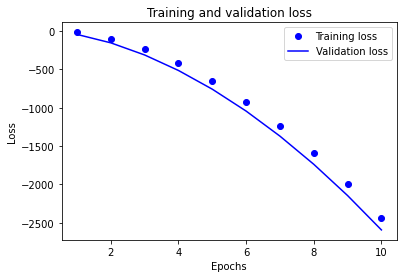

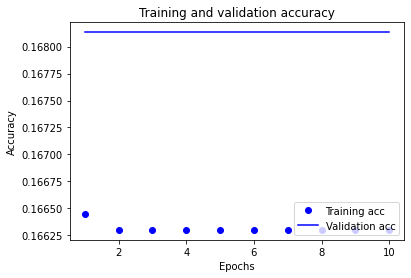

In [11]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [12]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

print(export_model.predict(examples))

782/782 [==============================] - 4s 5ms/step - loss: 2655.0171 - accuracy: 0.5000
0.5
[[1.]
 [1.]
 [1.]]
